In [6]:
import pandas as pd
import numpy as np
import os


#os.chdir("C:/Users/cuent/En-Peu/notebooks/")
print(os.getcwd())


C:\Users\cuent\En-Peu\notebooks


In [7]:
# Cambiar al directorio padre
os.chdir("..")
parent_directory = os.getcwd()

# os.path.join() maneja correctamente las barras de ruta para diferentes SO (Windows, Linux, macOS)
file_path = os.path.join(parent_directory, 'data', 'data_fin.csv')

# Cargar el archivo CSV
data = pd.read_csv(file_path)


# Verificar la estructura del DataFrame (equivalente a str(data) en R)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64345 entries, 0 to 64344
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POINT_X  64345 non-null  float64
 1   POINT_Y  64345 non-null  float64
 2   PLA      64345 non-null  float64
 3   A        64345 non-null  float64
 4   AC       64345 non-null  float64
 5   CIB      64345 non-null  float64
 6   CICCB    64345 non-null  float64
 7   DBB      64345 non-null  float64
 8   DOB      64345 non-null  float64
 9   P        64345 non-null  float64
 10  CUS_1    64345 non-null  float64
 11  CUS_2    64345 non-null  float64
 12  CUS_3    64345 non-null  float64
 13  CUS_4    64345 non-null  float64
 14  CUS_5    64345 non-null  float64
 15  OC_1     64345 non-null  float64
 16  OC_2     64345 non-null  float64
 17  OC_3     64345 non-null  float64
 18  OC_4     64345 non-null  float64
dtypes: float64(19)
memory usage: 9.3 MB
None


In [8]:
from sklearn.model_selection import train_test_split

# 1. Definir las características (X) y la variable objetivo (y)
# X serán todas las columnas excepto 'PLA' y las coordenadas
coordinates = data[['POINT_X', 'POINT_Y']].copy()
X = data.drop(columns=['PLA', 'POINT_X','POINT_Y'])
# y será la columna 'PLA'
y = data['PLA']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
# test_size=0.20 significa 20% para prueba, por lo tanto 80% para entrenamiento
# random_state=12345 asegura que la división sea reproducible
# shuffle=True (por defecto) asegura que los datos se mezclen antes de la división
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345
)

# Usa los índices de X_test_scaled para seleccionar las coordenadas originales
coordinates_test = coordinates.loc[X_test.index].copy()

# 4. Mostrar las formas de los nuevos DataFrames/Series para verificar
print("\nForma de X_train (características de entrenamiento):", X_train.shape)
print("Forma de y_train (etiquetas de entrenamiento):", y_train.shape)
print("Forma de X_test (características de prueba):", X_test.shape)
print("Forma de y_test (etiquetas de prueba):", y_test.shape)

print("\nPrimeras filas de X_train:")
print(X_train.head())
print("\nPrimeras filas de y_train:")
print(y_train.head())


Forma de X_train (características de entrenamiento): (51476, 16)
Forma de y_train (etiquetas de entrenamiento): (51476,)
Forma de X_test (características de prueba): (12869, 16)
Forma de y_test (etiquetas de prueba): (12869,)

Primeras filas de X_train:
              A        AC       CIB     CICCB       DBB       DOB         P  \
48196  0.634369  0.324476  0.101781  0.291697  0.484058  0.605235  0.036417   
31410  0.721612  0.027246  0.778726  0.541413  0.138255  0.208782  0.020722   
23835  0.534206  1.000000  0.043877  0.236189  0.285055  0.631355  0.000000   
53962  0.584288  0.324476  0.401558  0.193533  0.679098  0.738164  0.058812   
45212  0.805616  1.000000  0.816241  0.443402  0.213456  0.300115  0.032442   

       CUS_1  CUS_2  CUS_3  CUS_4  CUS_5  OC_1  OC_2  OC_3  OC_4  
48196    0.0    0.0    0.0    0.0    1.0   1.0   0.0   0.0   0.0  
31410    0.0    1.0    0.0    0.0    0.0   0.0   0.0   0.0   1.0  
23835    1.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   1.0  
53

In [9]:
import xgboost as xgb # Using XGBoost for GBM
from sklearn.model_selection import train_test_split, GridSearchCV # For cross-validation and hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # For evaluation metrics
import joblib # To save/load models and for parallel processing

# --- 1. Paralelización (Gestionado por scikit-learn con 'n_jobs') ---
# En Python con scikit-learn, la paralelización se maneja con el parámetro `n_jobs`.
# n_jobs = -1 significa usar todos los núcleos disponibles.
# n_jobs = -2 significa usar todos los núcleos excepto 1.
n_cores = joblib.cpu_count() - 1
print(f"\nDetectados {joblib.cpu_count()} núcleos, usando {n_cores} para paralelización.")


# --- 2. Control de validación cruzada (GridSearchCV) ---
# 'trainControl' de caret se traduce a GridSearchCV de scikit-learn
# metric = "RMSE" en R es 'neg_root_mean_squared_error' en scikit-learn (para minimizar)
# Ojo: GridSearchCV siempre intenta MAXIMIZAR la métrica, por eso es 'negativo RMSE'.
scoring_metric = 'neg_root_mean_squared_error' # Minimizar RMSE -> Maximizar -RMSE



Detectados 20 núcleos, usando 19 para paralelización.


In [10]:
# --- 3. GBM (Gradient Boosting Machine) con XGBoost ---

# Definir la cuadrícula de hiperparámetros para XGBoost
# Equivalencias:
# interaction.depth (R) -> max_depth (XGBoost)
# n.trees (R) -> n_estimators (XGBoost)
# shrinkage (R) -> learning_rate (XGBoost)
# n.minobsinnode (R) -> min_child_weight (XGBoost - similar pero no idéntico)
grid_gbm = {
    'max_depth': [1, 3],
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [10] # Un valor similar a n.minobsinnode
}

# Inicializar el modelo base (XGBoost Regressor para problemas de regresión)
# objective='reg:squarederror' es el objetivo estándar para regresión con RMSE
model_gbm_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Configurar GridSearchCV para la búsqueda de hiperparámetros y CV
modelo_gbm = GridSearchCV(
    estimator=model_gbm_base,
    param_grid=grid_gbm,
    cv=10, # 'number = 10' en trainControl
    scoring=scoring_metric,
    verbose=1, # Muestra el progreso
    n_jobs=n_cores, # Paralelización: usar todos los núcleos menos 1
    return_train_score=False # No necesitamos scores de entrenamiento para este caso
)

# Entrenar el modelo
print("\nIniciando entrenamiento del modelo GBM con GridSearchCV...")
modelo_gbm.fit(X_train, y_train)

# Mejores hiperparámetros
print("\nMejores hiperparámetros GBM:")
print(modelo_gbm.best_params_)

# Mejor score (RMSE negativo)
print(f"Mejor score de validación (neg_root_mean_squared_error): {modelo_gbm.best_score_:.4f}")
print(f"Mejor RMSE de validación: {-modelo_gbm.best_score_:.4f}")

# Guardar el modelo entrenado
# En Python, se usa 'joblib' o 'pickle' para guardar modelos. Joblib es preferido para modelos de scikit-learn.
joblib.dump(modelo_gbm.best_estimator_, 'modelo_gbm.pkl')
print("\nModelo GBM guardado como 'modelo_gbm.pkl'")



Iniciando entrenamiento del modelo GBM con GridSearchCV...
Fitting 10 folds for each of 8 candidates, totalling 80 fits

Mejores hiperparámetros GBM:
{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500}
Mejor score de validación (neg_root_mean_squared_error): -0.0261
Mejor RMSE de validación: 0.0261

Modelo GBM guardado como 'modelo_gbm.pkl'


In [11]:
# --- 4. Realizar Predicciones y Evaluar ---
# Cargar el modelo si no lo tienes en memoria (útil si guardas y cargas en otro script)
# loaded_model_gbm = joblib.load('modelo_gbm.pkl')

# Realizar predicciones sobre el conjunto de prueba
predicciones_gbm = modelo_gbm.predict(X_test) # Usamos el modelo optimizado de GridSearchCV

# Evaluar métricas (similar a postResample en R)
# RMSE
rmse_gbm = np.sqrt(mean_squared_error(y_test, predicciones_gbm))
# R-squared (coeficiente de determinación)
r2_gbm = r2_score(y_test, predicciones_gbm)
# para MAE usar mean_absolute_error de sklearn.metrics
mae_gbm = mean_absolute_error(y_test, predicciones_gbm)

print(f"\nRMSE en el conjunto de prueba para GBM: {rmse_gbm:.4f}")
print(f"R-squared en el conjunto de prueba para GBM: {r2_gbm:.4f}")
print(f"MAE en el conjunto de prueba para GBM: {mae_gbm:.4f}")


RMSE en el conjunto de prueba para GBM: 0.0264
R-squared en el conjunto de prueba para GBM: 0.8587
MAE en el conjunto de prueba para GBM: 0.0169


In [12]:
# --- 5. Importancia de Variables (similar a varImp en R) ---
# La importancia de variables está disponible en el mejor estimador del modelo GBM
print("\nImportancia de variables GBM:")
# Asegúrate de que las columnas de X_train sean un índice para el resultado de importancia
feature_importances_gbm = pd.Series(modelo_gbm.best_estimator_.feature_importances_, index=X_train.columns)
print(feature_importances_gbm.sort_values(ascending=False))


Importancia de variables GBM:
CIB      0.165937
CUS_1    0.158509
DOB      0.101162
CICCB    0.093892
P        0.088247
A        0.087992
DBB      0.084106
CUS_5    0.049671
OC_3     0.043368
AC       0.029474
CUS_4    0.024958
CUS_3    0.023386
OC_2     0.017748
OC_1     0.012580
OC_4     0.009800
CUS_2    0.009167
dtype: float32


In [13]:
# Queremos ver los resultados desnormalizados. 
# Cargar el scaler guardado en el notebook anterior
scaler_path = os.path.join(parent_directory, 'data','min_max_scaler.pkl')
loaded_scaler = joblib.load(scaler_path)

min_pla = loaded_scaler.data_min_[1]
range_pla = loaded_scaler.data_range_[1]

# Desnormalizar manualmente con los min/max específicos de PLA
predicciones_gbm_desnormalized = predicciones_gbm * range_pla + min_pla
y_test_desnormalized = y_test * range_pla + min_pla


print(f"Predicciones desnormalizadas (primeras 5): {predicciones_gbm_desnormalized[:5]}")
print(f"Valores reales desnormalizados (primeras 5): {y_test_desnormalized[:5]}")

Predicciones desnormalizadas (primeras 5): [3.9273643 2.7326806 3.9420128 3.8108962 7.226899 ]
Valores reales desnormalizados (primeras 5): 59999    5.194245
21880    3.371575
26228    3.589025
51256    3.223600
33816    7.220004
Name: PLA, dtype: float64


In [14]:
# --- Calcular métricas con valores desnormalizados ---
rmse_desnormalized_gbm = np.sqrt(mean_squared_error(y_test_desnormalized, predicciones_gbm_desnormalized))
mae_desnormalized_gbm = mean_absolute_error(y_test_desnormalized, predicciones_gbm_desnormalized)
r2_desnormalized_gbm = r2_score(y_test_desnormalized, predicciones_gbm_desnormalized)

print(f"\n--- Métricas en la ESCALA ORIGINAL (desnormalizada) ---")
print(f"RMSE: {rmse_desnormalized_gbm:.4f}")
print(f"MAE: {mae_desnormalized_gbm:.4f}")
print(f"R-squared: {r2_desnormalized_gbm:.4f}")


--- Métricas en la ESCALA ORIGINAL (desnormalizada) ---
RMSE: 0.7893
MAE: 0.5065
R-squared: 0.8587


In [15]:
##################################
### 2. Random Forest
##################################


from sklearn.ensemble import RandomForestRegressor # For Random Forest

# Definir la cuadrícula de hiperparámetros para RandomForestRegressor
# Equivalencias:
# mtry (R, randomForest package) -> max_features (scikit-learn)
# max_features es el número de características a considerar para el mejor split
# ntree (R) -> n_estimators (scikit-learn)
grid_rf = {
    'n_estimators': [500], # Corresponde a 'ntree = 500' en R (si no lo pusiste en tuneGrid)
                            # Para tunearlo, poner c(100, 500)
    'max_features': [2, 5, 10], # Corresponde a 'mtry'
    'random_state': [42] # Para reproducibilidad del modelo RF
}

# Inicializar el modelo base (RandomForestRegressor para regresión)
model_rf_base = RandomForestRegressor()

# Configurar GridSearchCV para la búsqueda de hiperparámetros y CV
modelo_rf_grid = GridSearchCV(
    estimator=model_rf_base,
    param_grid=grid_rf,
    cv=10, # 'number = 10' en trainControl
    scoring=scoring_metric,
    verbose=1, # Muestra el progreso
    n_jobs=n_cores, # Paralelización: usar todos los núcleos menos 1
    return_train_score=False
)

# Entrenar el modelo
print("\nIniciando entrenamiento del modelo Random Forest con GridSearchCV...")
modelo_rf_grid.fit(X_train, y_train)

# Mejores hiperparámetros
print("\nMejores hiperparámetros Random Forest:")
print(modelo_rf_grid.best_params_)

# Mejor score (RMSE negativo)
print(f"Mejor score de validación (neg_root_mean_squared_error): {modelo_rf_grid.best_score_:.4f}")
print(f"Mejor RMSE de validación: {-modelo_rf_grid.best_score_:.4f}")

# Guardar el modelo entrenado
#model_rf_path = 'modelo_rf.pkl'
#joblib.dump(modelo_rf_grid.best_estimator_, model_rf_path)
#print(f"\nModelo Random Forest guardado como '{model_rf_path}'")



Iniciando entrenamiento del modelo Random Forest con GridSearchCV...
Fitting 10 folds for each of 3 candidates, totalling 30 fits

Mejores hiperparámetros Random Forest:
{'max_features': 10, 'n_estimators': 500, 'random_state': 42}
Mejor score de validación (neg_root_mean_squared_error): -0.0146
Mejor RMSE de validación: 0.0146

Modelo Random Forest guardado como 'modelo_rf.pkl'


In [17]:
# --- 4. Realizar Predicciones y Evaluar ---
# Realizar predicciones sobre el conjunto de prueba (en la escala normalizada)
predicciones_rf = modelo_rf_grid.predict(X_test)
print(f"Predicciones en escala normalizada (primeras 5): {predicciones_rf[:5]}")

Predicciones en escala normalizada (primeras 5): [0.13416236 0.11079212 0.11809772 0.10817017 0.23784186]


In [18]:
# --- DESNORMALIZAR LAS PREDICCIONES Y LOS VALORES REALES DE PRUEBA ---

# Desnormalizar manualmente con los min/max específicos de PLA
predicciones_rf_desnormalized = predicciones_rf * range_pla + min_pla
y_test_desnormalized = y_test * range_pla + min_pla


print(f"Predicciones desnormalizadas (primeras 5): {predicciones_rf_desnormalized[:5]}")
print(f"Valores reales desnormalizados (primeras 5): {y_test_desnormalized[:5]}")

Predicciones desnormalizadas (primeras 5): [4.01829677 3.31833492 3.53714477 3.2398049  7.12360148]
Valores reales desnormalizados (primeras 5): 59999    5.194245
21880    3.371575
26228    3.589025
51256    3.223600
33816    7.220004
Name: PLA, dtype: float64


In [19]:
# --- Calcular métricas con valores desnormalizados ---
rmse_desnormalized_rf = np.sqrt(mean_squared_error(y_test_desnormalized, predicciones_rf_desnormalized))
mae_desnormalized_rf = mean_absolute_error(y_test_desnormalized, predicciones_rf_desnormalized)
r2_desnormalized_rf = r2_score(y_test_desnormalized, predicciones_rf_desnormalized)

print(f"\n--- Métricas en la ESCALA ORIGINAL (desnormalizada) ---")
print(f"RMSE: {rmse_desnormalized_rf:.4f}")
print(f"MAE: {mae_desnormalized_rf:.4f}")
print(f"R-squared: {r2_desnormalized_rf:.4f}")


--- Métricas en la ESCALA ORIGINAL (desnormalizada) ---
RMSE: 0.4088
MAE: 0.1470
R-squared: 0.9621


Podemos ver que el modelo Random Forest tiene un R cuadrado de 0.962, y un RMSE y un MAE muy bajos, de 41 y 15 centímetros. Este modelo muestra buenos resultados.

In [20]:
# --- 5. Importancia de Variables (similar a varImp en R) ---
# La importancia de variables está disponible en el mejor estimador del modelo RF
print("\nImportancia de variables RF:")
# Asegúrate de que las columnas de X_train sean un índice para el resultado de importancia
feature_importances_rf = pd.Series(modelo_rf_grid.best_estimator_.feature_importances_, index=X_train.columns)
print(feature_importances_rf.sort_values(ascending=False))


Importancia de variables RF:
CIB      0.273433
DOB      0.168923
A        0.152707
CICCB    0.149512
DBB      0.147162
P        0.063631
AC       0.022859
CUS_1    0.006608
CUS_4    0.004146
OC_3     0.003272
CUS_3    0.001789
CUS_5    0.001673
OC_4     0.001668
OC_2     0.001030
CUS_2    0.000827
OC_1     0.000762
dtype: float64


In [21]:
# Guardar los resultados en un diccionario y crear una tabla de resultados

# Crear un diccionario con los resultados
results_data = {
    'Métrica': ['RMSE', 'MAE', 'R-squared'],
    'Random Forest': [rmse_desnormalized_rf, mae_desnormalized_rf, r2_desnormalized_rf],
    'GBM (XGBoost)': [rmse_desnormalized_gbm, mae_desnormalized_gbm, r2_desnormalized_gbm]
}

# Convertir el diccionario a un DataFrame de pandas
results_df = pd.DataFrame(results_data)

# Redondear los valores para una mejor presentación
results_df_rounded = results_df.round(4)

print("--- Comparación de Resultados de Modelos ---")
print(results_df_rounded.to_string(index=False)) # .to_string(index=False) para no mostrar el índice del DataFrame


--- Comparación de Resultados de Modelos ---
  Métrica  Random Forest  GBM (XGBoost)
     RMSE         0.4088         0.7893
      MAE         0.1470         0.5065
R-squared         0.9621         0.8587


DataFrame de métricas para graficar:
          Modelo    RMSE     MAE  R-squared
0  Random Forest  0.4088  0.1470     0.9621
1  GBM (XGBoost)  0.7893  0.5065     0.8587


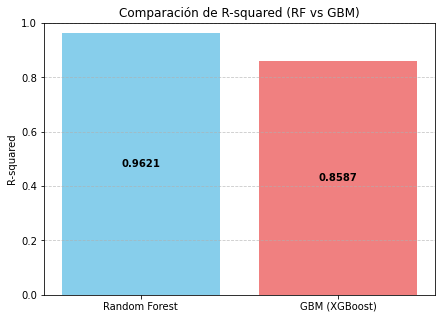

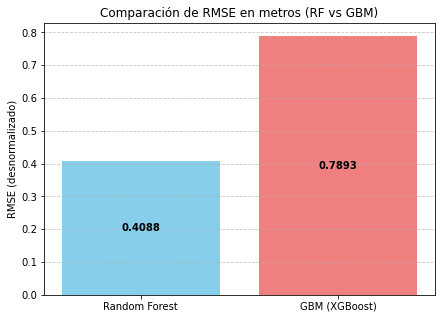

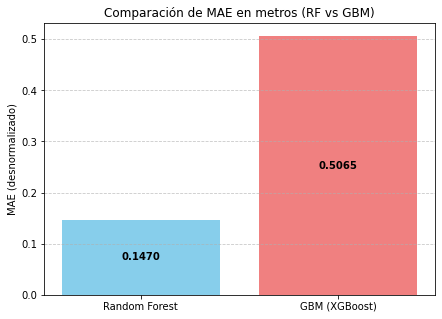

In [22]:
#  Visualización de un gráfico de barras
# Puedes elegir qué métrica quieres visualizar si lo deseas. Por ejemplo, RMSE.
# Crear un DataFrame para la gráfica de RMSE

import matplotlib.pyplot as plt

# Crear un DataFrame para facilitar la graficación de comparaciones
metrics_df = pd.DataFrame({
    'Modelo': ['Random Forest', 'GBM (XGBoost)'],
    'RMSE': [rmse_desnormalized_rf, rmse_desnormalized_gbm],
    'MAE': [mae_desnormalized_rf, mae_desnormalized_gbm],
    'R-squared': [r2_desnormalized_rf, r2_desnormalized_gbm]
})

print("DataFrame de métricas para graficar:")
print(metrics_df.round(4))

# --- Crear las tres gráficas separadas para comparación ---


# --- Crear las tres gráficas separadas para comparación ---

# Gráfica 1: Comparación de R-squared
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics_df['Modelo'], metrics_df['R-squared'], color=['skyblue', 'lightcoral'])
plt.title('Comparación de R-squared (RF vs GBM)')
plt.ylabel('R-squared')
plt.ylim(0, 1) # R-squared typically ranges from 0 to 1
# Añadir valores DENTRO de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, # Posición X en el centro de la barra, Y a la mitad de la altura
             f'{yval:.4f}', ha='center', va='center', color='black',
             fontsize=10, weight='bold') # Ajusta color y tamaño si es necesario
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar la figura en el directorio
plt.savefig(os.path.join(parent_directory, 'images','R2_gbm_rf.png'), bbox_inches='tight', dpi=300)
plt.show()

# Gráfica 2: Comparación de RMSE
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics_df['Modelo'], metrics_df['RMSE'], color=['skyblue', 'lightcoral'])
plt.title('Comparación de RMSE en metros (RF vs GBM)')
plt.ylabel('RMSE (desnormalizado)')
# Añadir valores DENTRO de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, # Posición X en el centro de la barra, Y a la mitad de la altura
             f'{yval:.4f}', ha='center', va='center', color='black',
             fontsize=10, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar la figura en el directorio
plt.savefig(os.path.join(parent_directory, 'images','RMSE_gbm_rf.png'), bbox_inches='tight', dpi=300)

plt.show()

# Gráfica 3: Comparación de MAE
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics_df['Modelo'], metrics_df['MAE'], color=['skyblue', 'lightcoral'])
plt.title('Comparación de MAE en metros (RF vs GBM)')
plt.ylabel('MAE (desnormalizado)')
# Añadir valores DENTRO de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, # Posición X en el centro de la barra, Y a la mitad de la altura
             f'{yval:.4f}', ha='center', va='center', color='black',
             fontsize=10, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar la figura en el directorio
plt.savefig(os.path.join(parent_directory, 'images','MAE_gbm_rf.png'), bbox_inches='tight', dpi=300)

plt.show()


DataFrame para el mapa (primeras 5 filas):
             POINT_X       POINT_Y  PLA_Real  PLA_Predicho
59999  723539.712912  4.368119e+06  5.194245      4.018297
21880  723069.078224  4.366624e+06  3.371575      3.318335
26228  723022.390076  4.366947e+06  3.589025      3.537145
51256  722727.906662  4.367564e+06  3.223600      3.239805
33816  722147.814710  4.367393e+06  7.220004      7.123601

DataFrame combinado guardado exitosamente como 'mapa_PLA_real_predicho.csv' en 'C:\Users\cuent\En-Peu\data\mapa_PLA_real_predicho.csv'


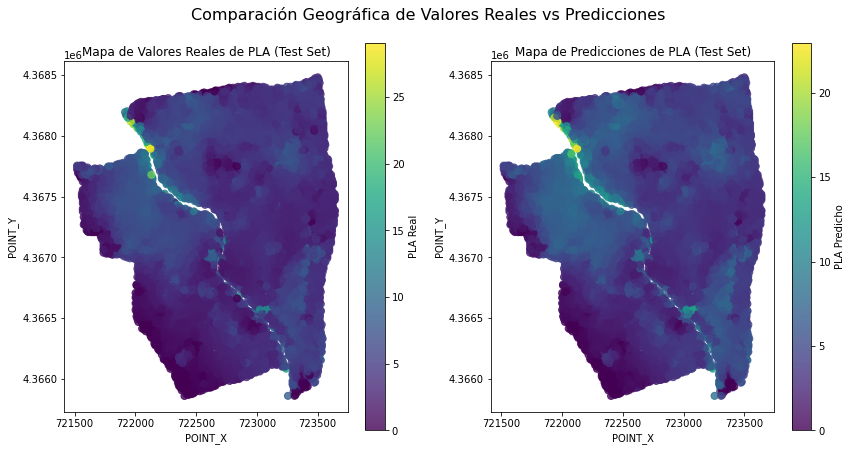

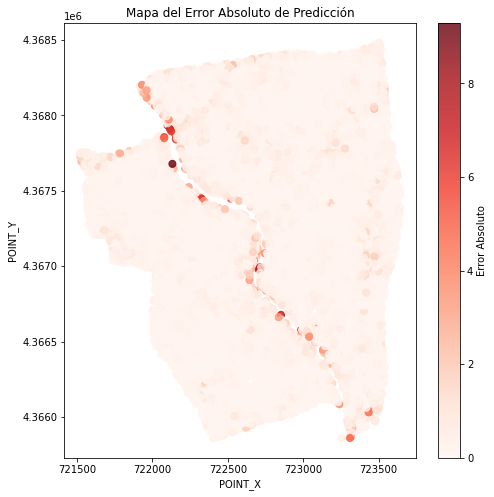

In [23]:
# --- COMBINAR COORDENADAS Y PREDICCIONES PARA EL MAPA ---
# Crear un DataFrame con los valores reales, predicciones y coordenadas para el conjunto de prueba
map_data = pd.DataFrame({
    'POINT_X': coordinates_test['POINT_X'],
    'POINT_Y': coordinates_test['POINT_Y'],
    'PLA_Real': y_test_desnormalized,
    'PLA_Predicho': predicciones_rf_desnormalized
})

print("\nDataFrame para el mapa (primeras 5 filas):")
print(map_data.head())

# Guardar el resultado en un nuevo CSV
nombre_archivo_salida = "mapa_PLA_real_predicho.csv"
map_data.to_csv(os.path.join(parent_directory,'data',nombre_archivo_salida), index=False) # index=False evita guardar el índice de pandas como una columna

print(f"\nDataFrame combinado guardado exitosamente como '{nombre_archivo_salida}' en '{os.path.join(parent_directory,'data',nombre_archivo_salida)}'")

# --- HACER EL MAPA DE LAS PREDICCIONES ---


plt.figure(figsize=(12, 6))

# Gráfico de dispersión para los valores reales
ax1 = plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primer gráfico
scatter1 = ax1.scatter(map_data['POINT_X'], map_data['POINT_Y'],
                       c=map_data['PLA_Real'], cmap='viridis', s=50, alpha=0.8)
ax1.set_title('Mapa de Valores Reales de PLA (Test Set)')
ax1.set_xlabel('POINT_X')
ax1.set_ylabel('POINT_Y')
plt.colorbar(scatter1, ax=ax1, label='PLA Real')
ax1.set_aspect('equal', adjustable='box') # CORRECTED: Called on ax1

# Gráfico de dispersión para las predicciones
ax2 = plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segundo gráfico
scatter2 = ax2.scatter(map_data['POINT_X'], map_data['POINT_Y'],
                       c=map_data['PLA_Predicho'], cmap='viridis', s=50, alpha=0.8)
ax2.set_title('Mapa de Predicciones de PLA (Test Set)')
ax2.set_xlabel('POINT_X')
ax2.set_ylabel('POINT_Y')
plt.colorbar(scatter2, ax=ax2, label='PLA Predicho')
ax2.set_aspect('equal', adjustable='box') # CORRECTED: Called on ax2

plt.tight_layout()
plt.suptitle('Comparación Geográfica de Valores Reales vs Predicciones', y=1.05, fontsize=16)

# Guardar la figura en el directorio
plt.savefig(os.path.join(parent_directory, 'images','mapa_predicciones_PLA.png'), bbox_inches='tight', dpi=300)

plt.show()

# Opcional: Para visualizar las diferencias (errores)
plt.figure(figsize=(8, 8))
# Calcular el error absoluto para colorear
map_data['Error_Absoluto'] = np.abs(map_data['PLA_Real'] - map_data['PLA_Predicho'])
ax_error = plt.gca() # Get the current Axes object for this single subplot
scatter_error = ax_error.scatter(map_data['POINT_X'], map_data['POINT_Y'], # CORRECTED: Use ax_error for scatter
                            c=map_data['Error_Absoluto'], cmap='Reds', s=50, alpha=0.8)
ax_error.set_title('Mapa del Error Absoluto de Predicción') # CORRECTED: Set title on ax_error
ax_error.set_xlabel('POINT_X') # CORRECTED: Set xlabel on ax_error
ax_error.set_ylabel('POINT_Y') # CORRECTED: Set ylabel on ax_error
plt.colorbar(scatter_error, ax=ax_error, label='Error Absoluto') # CORRECTED: Pass ax=ax_error to colorbar
ax_error.set_aspect('equal', adjustable='box') # CORRECTED: Called on ax_error

# Guardar la figura en el directorio
plt.savefig(os.path.join(parent_directory, 'images','mapa_error_absoluto.png'), bbox_inches='tight', dpi=300)


plt.show()

In [ ]:
Y ahora vemos un gráfico de dispersión entre valores predichos y observados

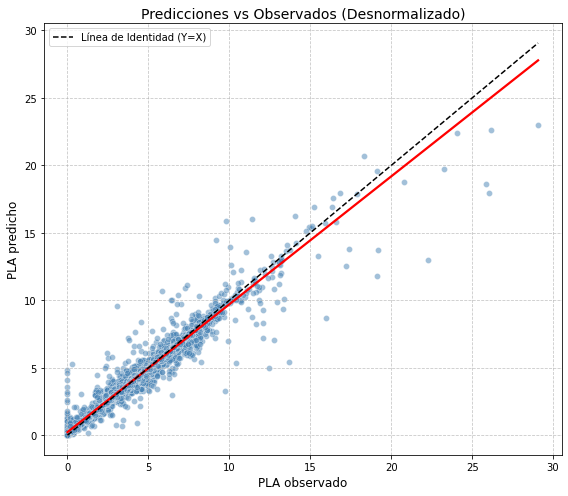

In [25]:
import seaborn as sns

# observado = y_test_desnormalized
# predicho = predicciones_rf_desnormalized

# Crear un DataFrame para ggplot/seaborn
plot_df = pd.DataFrame({
    'Observado': y_test_desnormalized,
    'Predicho': predicciones_rf_desnormalized
})

# --- Graficar ---
plt.figure(figsize=(8, 7))

# 1. Gráfico de dispersión
sns.scatterplot(data=plot_df, x='Observado', y='Predicho', alpha=0.5, color="steelblue")

# 2. Línea de regresión (geom_smooth(method = "lm", se = FALSE) en R)
# 'regplot' de seaborn es el equivalente más directo a geom_smooth(method="lm")
sns.regplot(data=plot_df, x='Observado', y='Predicho', scatter=False, color="red", line_kws={'linestyle':'solid'}, ci=None)

# 3. Línea de identidad (geom_abline(slope = 1, intercept = 0) en R)
plt.plot([plot_df['Observado'].min(), plot_df['Observado'].max()],
         [plot_df['Observado'].min(), plot_df['Observado'].max()],
         linestyle='dashed', color='black', label='Línea de Identidad (Y=X)')

# 4. Etiquetas y título
plt.title("Predicciones vs Observados (Desnormalizado)", fontsize=14)
plt.xlabel("PLA observado", fontsize=12)
plt.ylabel("PLA predicho", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) # Añadir una cuadrícula
plt.legend() # Mostrar la leyenda para la línea de identidad
plt.tight_layout() # Ajustar el diseño

# Guardar la figura en el directorio
plt.savefig(os.path.join(parent_directory, 'images','dispersion_observado_predicho.png'), bbox_inches='tight', dpi=300)

plt.show()